# Customer segmentation

This workbook consist of two parts; a customer segmentation analysis and a customer life time value prediction. 
A customer segmentation analysis is crucial for business in order to identify and understand their customers needs and behaviors. If Olist wants to take direct actions in order to increase the revenue of customers then it needs to take different actions based on the different needs the customers might have. 

In this report, the Recency-Frequency-Monetary (RFM) - clustering method has been chosen. The RFM method is used to analyse the value of a customer by the following three dimensions :

 - Recency: How recently did the customer purchase?  
 - Frequency: How often do they purchase? 
 - Monetary: How much do they spend? 
 
Each customer will get a combined RFM score.

In [65]:
# Import
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import datetime as dt
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

### Import of data 

The workbook will focus on the customer part of the OLIST dataset. Therefore, only the following datasets are joined:

- olist_customers_dataset
- olist_order_payments_dataset
- olist_orders_dataset

These are joined by the left-join operation and dataformat is set. 

In [66]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

cop.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


### KPIs and Metrics

In order to measure Olist business performance, a number of KPIs can be defined. The KPIs enables the team to measure the performance of their strategy and indicates poor performing areas of the business.

The following KPIs have been defined as important for Olist: 

- Monthly revenue 
- Monthy growth rate
- Number of active customers each month
- Number of returning customers each month/quarter


In the following section, the above KPIs will be calculated and presented. 

In [90]:
#Monthly revenue
cop['PurchaseMonth'] = cop['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

cop_MonthlyRevenue  = cop.groupby(['PurchaseMonth'])['payment_value'].sum().reset_index()

cop_MonthlyRevenue


,PurchaseMonth,payment_value
0,201609,136.23
1,201610,53915.50
2,201612,19.62
3,201701,138119.76
4,201702,289081.01
5,201703,442406.37
6,201704,409846.01
7,201705,588529.96
8,201706,507302.62
9,201707,585331.36


In [91]:
#Finding the quarterly revenue and plotting that (fewer datapoint to visualise)
cop['quarter'] = pd.PeriodIndex(cop.order_purchase_timestamp, freq='Q')

cop_revenue  = cop.groupby(['quarter'])['payment_value'].sum().reset_index()


cop_revenue

,quarter,payment_value
0,2016Q3,136.23
1,2016Q4,53935.12
2,2017Q1,869607.14
3,2017Q2,1505678.59
4,2017Q3,1976337.10
5,2017Q4,2835290.94
6,2018Q1,3250497.95
7,2018Q2,3328040.12
8,2018Q3,2046093.33


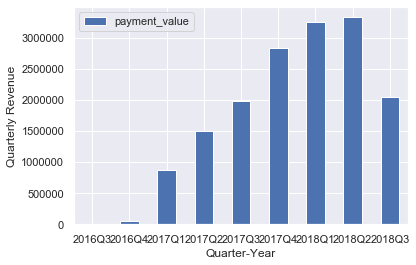

In [85]:
ax = cop_revenue.plot.bar(x='quarter', y='payment_value', rot=0)
plt.xlabel('Quarter-Year')
plt.ylabel('Quarterly Revenue')
plt.show()

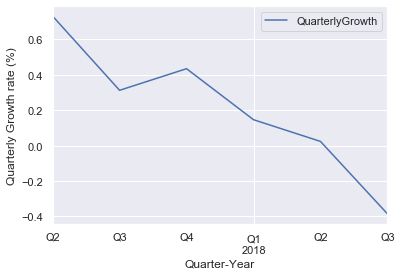

In [86]:
#calculating the quarterly growthrate and plotting it

cop_revenue['QuarterlyGrowth'] = cop_revenue['payment_value'].pct_change()


cop_revenue[3:].plot(x='quarter',y='QuarterlyGrowth')
plt.xlabel('Quarter-Year')
plt.ylabel('Quarterly Growth rate (%)')
plt.show()

In [17]:
# Distribution of how many times customers are returning to buy at Olist
customer_order.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

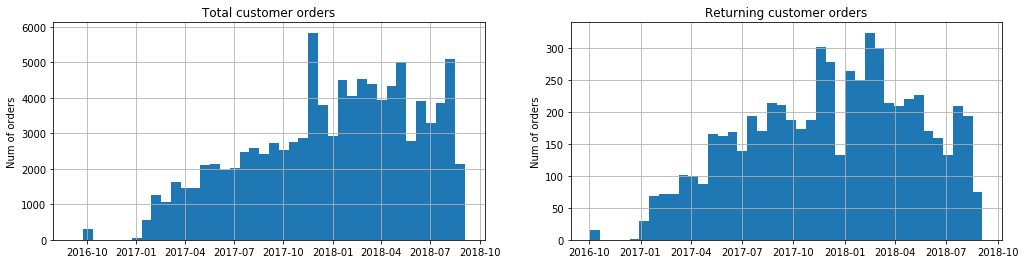

In [18]:
# The total customer order per month  and the amount of returning orders are visualised in the two plots below. 

plt.figure(figsize=(17, 4))
    
plt.subplot(1, 2, 1)
plt.title('Total customer orders')
plt.ylabel('Num of orders')
cop.order_purchase_timestamp.hist(bins=40)

plt.subplot(1, 2, 2)
plt.ylabel('Num of orders')
plt.title('Returning customer orders')
unique_id = cop.groupby('customer_unique_id').count()
later_purchase = cop[cop.customer_unique_id.isin(list(unique_id[unique_id.customer_id > 1].index))]
later_purchase.order_purchase_timestamp.hist(bins=40)
plt.show()

The threee parts of RFM is calculated now. The data is grouped by the unique customer id.
Recency is calculated with the difference between the lastest purchasing date in the data set subtracted with the purchase date of the observation.
Frequency is calculated by counting the amount of purchase timestamps each customer have. 
Revenue is calculated by summing each customer's payment_value. 


We are going to apply K-means clustering to assign a score for each dimension in RFM. K-means require that we specify K clusters. This can be done from the Elbow method which tells us the optimal number of clusters.


In [19]:
# Helper functions
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

def plot_cluster(data, name):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title('Optimal number of clusters via Elbow of: ' + name)
    plt.xlabel("Number of cluster")
    plt.ylabel("Inertia")
    plt.show()

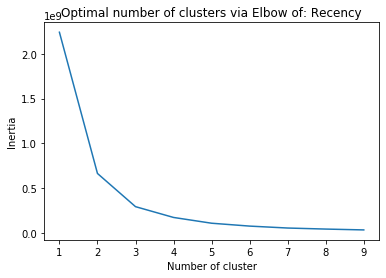

In [20]:
# Recency
df_recency = cop.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','last_purchase_date']
df_recency['Recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days
df_recency = df_recency[['customer_unique_id','Recency']]

# Frequency
df_frequency = cop.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Revenue
df_revenue = cop.groupby('customer_unique_id').payment_value.sum().reset_index()
df_revenue.columns = ['customer_unique_id','Revenue']

df = pd.DataFrame(cop['customer_unique_id'].unique())
df.columns = ['customer_unique_id']

sort_orders = [False, True, True]
names = ['Recency','Frequency','Revenue']
dfs = [df_recency, df_frequency, df_revenue]

for i in range(len(['Recency','Frequency','Revenue'])):
    df = pd.merge(df, dfs[i], on='customer_unique_id')
    kmeans = KMeans(n_clusters=4)
    
    if names[i] == "Recency":
        plot_cluster(df[[names[i]]], names[i])
        
    kmeans.fit(df[[names[i]]])
    df['cluster_' + names[i]] = kmeans.predict(df[[names[i]]])
    df = order_cluster('cluster_' + names[i], names[i], df, sort_orders[i])
    
df['OverallScore'] = df['cluster_Recency'] + df['cluster_Frequency'] + df['cluster_Revenue']

The optimal number of clusters is 4

In [21]:
overview = df.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()
overview['Count'] = df.groupby('OverallScore')['customer_unique_id'].count()
overview

,Recency,Frequency,Revenue,Count
OverallScore,,,,
0,488.050177,1.000000,91.218221,13253
1,342.055561,1.008610,120.433994,22300
2,217.761595,1.019180,142.385308,26434
3,101.902720,1.028625,166.739202,25956
4,97.791702,1.146729,401.412864,5977
5,88.501110,1.441155,775.937091,1351
6,77.400810,1.834008,1537.073279,247
7,104.666667,3.545455,1140.622424,33
8,52.888889,6.666667,1610.453333,9


In [22]:
df['Segment'] = 'Low-Value'
df.loc[df['OverallScore']>1,'Segment'] = 'Mid-Value' 
df.loc[df['OverallScore']>3,'Segment'] = 'High-Value' 

plot = df[(df['Revenue']<7000) & (df['Frequency']<6)]

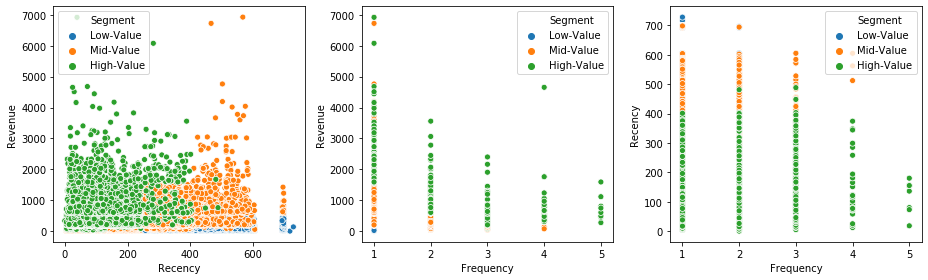

In [23]:
plt.figure(figsize=(13, 4))
    
ax0_names = ['Recency','Frequency','Frequency']
ax1_names = ['Revenue','Revenue','Recency']

for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(ax0_names[i], ax1_names[i], hue='Segment', data=plot)

plt.tight_layout()
plt.show()

# Customer Lifetime Value

According to a study by Bain & Company, existing customers tend to buy more from a company over time, thus reducing the operating costs of the business and may refer the products they use to others. For example, in financial services, a 5% increase in customer retention produces more than a 25% increase in profit.
This emphasizes why it is important for OLIST to focus and measure how many active customers they have. 

we have chosen The lifetime value (LTV) to be 6 months so the period will be from the 01/01/2018 - 01/06/2018
and we take 12 months of data to calculate the RFM and use it for predicting the next 6 months. The 12-month period will stretch from 01/01/2017 - 01/01/2018

In [24]:
from datetime import datetime, timedelta, date
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [40]:
# Create 12m and 6m dataframes
tx_12m = cop[(cop.order_purchase_timestamp < pd.Timestamp(2017,10,1)) & (cop.order_purchase_timestamp >= pd.Timestamp(2017,1,1))].reset_index(drop=True)
tx_6m = cop[(cop.order_purchase_timestamp >= pd.Timestamp(2017,10,1)) & (cop.order_purchase_timestamp < pd.Timestamp(2018,6,1))].reset_index(drop=True)

In [41]:
# Recency 12m
df_recency = tx_12m.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','last_purchase_date']
df_recency['Recency'] = (df_recency['last_purchase_date'].max() - df_recency['last_purchase_date']).dt.days
df_recency = df_recency[['customer_unique_id','Recency']]

# Frequency 12m
df_frequency = tx_12m.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# Revenue 12m
df_revenue = tx_12m.groupby('customer_unique_id').payment_value.sum().reset_index()
df_revenue.columns = ['customer_unique_id','Revenue']

df_12m = pd.DataFrame(tx_12m['customer_unique_id'].unique())
df_12m.columns = ['customer_unique_id']

sort_orders = [False, True, True]
names = ['Recency','Frequency','Revenue']
dfs = [df_recency, df_frequency, df_revenue]

for i in range(len(['Recency','Frequency','Revenue'])):
    df_12m = pd.merge(df_12m, dfs[i], on='customer_unique_id')
    kmeans = KMeans(n_clusters=4)        
    kmeans.fit(df_12m[[names[i]]])
    df_12m['cluster_' + names[i]] = kmeans.predict(df_12m[[names[i]]])
    df_12m = order_cluster('cluster_' + names[i], names[i], df_12m, sort_orders[i])
    
df_12m['OverallScore'] = df_12m['cluster_Recency'] + df_12m['cluster_Frequency'] + df_12m['cluster_Revenue']

In [42]:
df_12m['Segment'] = 'Low-Value'
df_12m.loc[df['OverallScore']>1,'Segment'] = 'Mid-Value' 
df_12m.loc[df['OverallScore']>3,'Segment'] = 'High-Value' 

plot = df_12m[(df_12m['Revenue']<7000) & (df_12m['Frequency']<6)]

### 6 month LTV

Now the 6 month LTV is calculated for each customer

In [43]:
tx_user_6m.head()

,customer_unique_id,m6_Revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f6ccb0745a6a4b88665a16c9f078,43.62
3,0004aac84e0df4da2b147fca70cf8255,196.89
4,0004bd2a26a76fe21f786e4fbd80607f,166.98


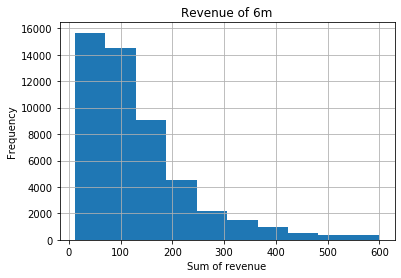

In [44]:
# Calculate revenue and create a new dataframe for it
tx_user_6m = tx_6m.groupby('customer_unique_id')['payment_value'].sum().reset_index()
tx_user_6m.columns = ['customer_unique_id','m6_Revenue']

# Plotting
tx_user_6m['m6_Revenue'][tx_user_6m['m6_Revenue']<600].hist()
plt.ylabel('Frequency')
plt.xlabel('Sum of revenue')
plt.title('Revenue of 6m')
plt.show()

Now we will merge our 3 months and 6 months dataframes to see correlations between LTV and the features set we have - (taget fra nettet skal ændres!)

In [45]:
tx_merge = pd.merge(df_12m, tx_user_6m, on='customer_unique_id', how='left')
#tx_merge = tx_merge.fillna(0)

tx_merge.head()
#insert scatter plot her af RFM score vs 6m LTV

,customer_unique_id,Recency,cluster_Recency,Frequency,cluster_Frequency,Revenue,cluster_Revenue,OverallScore,Segment,m6_Revenue
0,861eff4711a542e4b93843c6dd7febb0,137,1,1,0,146.87,0,1,Low-Value,NaN
1,7f3a72e8f988c6e735ba118d54f47458,142,1,1,0,102.03,0,1,Low-Value,NaN
2,4390ddbb6276a66ff1736a6710205dca,169,1,1,0,94.63,0,1,Low-Value,NaN
3,2e6a42a9b5cbb0da62988694f18ee295,138,1,1,0,47.59,0,1,Low-Value,NaN
4,fd2d5fdb84e65fa6b54b98b0e2df5645,131,1,1,0,80.57,0,1,Low-Value,NaN


In [46]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,388.0,93.216366,43.829355,15.89,55.3075,88.655,130.8775,180.51
1,100.0,273.550100,63.001244,184.73,220.8700,267.305,314.3375,435.95
2,22.0,610.989091,98.363437,453.80,543.2925,616.970,665.2375,785.24


In [47]:
tx_cluster.head()

,customer_unique_id,Recency,cluster_Recency,Frequency,cluster_Frequency,Revenue,cluster_Revenue,OverallScore,Segment,m6_Revenue,LTVCluster
0,18e3d276253780b44b5b7bf83f6785ec,150,1,1,0,96.88,0,1,Low-Value,71.97,0
1,49d1599dd80dedc213037342bbe43fd7,120,1,1,0,40.77,0,1,Low-Value,77.80,0
2,2b952792a20f6076f6e7a9c6a27ade02,117,1,1,0,47.54,0,1,Low-Value,82.60,0
3,f7d2fc6f0a2778f53d2a6bfc27bd0e8c,137,1,1,0,190.33,0,1,Low-Value,179.86,0
4,f11451a120b48a5c4c36d3274f0fd80c,148,1,1,0,224.29,0,1,Low-Value,28.58,0


In [48]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster, columns=['Segment'])

In [49]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster           1.000000
m6_Revenue           0.903187
cluster_Revenue      0.239816
Revenue              0.232252
cluster_Frequency    0.181156
Frequency            0.171613
OverallScore         0.152071
Segment_Mid-Value    0.083178
cluster_Recency      0.048547
Recency             -0.048607
Segment_Low-Value   -0.083178
Name: LTVCluster, dtype: float64

In [94]:
from sklearn.preprocessing import MinMaxScaler

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['customer_unique_id','LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=56)

### Dummy baseline

Having a high class imbalance we first create a baseline "dummy" classifier to later compare with a more advanced model.

In [95]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

clf = DummyClassifier(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74        55
           1       0.14      0.12      0.13        16
           2       0.50      0.17      0.25         6

    accuracy                           0.60        77
   macro avg       0.45      0.36      0.37        77
weighted avg       0.57      0.60      0.58        77



### Logistic regression 

Creating a simple classifier to later compare with a more advanced model

In [101]:
#class_weight='balanced' er til, skal vendes med Stannislav 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial',class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.42      0.55        55
           1       0.26      0.50      0.34        16
           2       0.17      0.50      0.25         6

    accuracy                           0.44        77
   macro avg       0.42      0.47      0.38        77
weighted avg       0.65      0.44      0.49        77



In [97]:
clf.coef_

array([[ 0.40898097,  0.10669708, -0.20427781, -0.30250783, -1.17012538,
        -0.66812845, -0.27481274, -0.00951158,  0.00947577],
       [ 0.72732727, -0.26487315,  0.80838812,  1.29445208, -1.10653835,
         0.67739625,  0.6347899 ,  0.21618882, -0.21665538],
       [-1.13630823,  0.15817607, -0.60411031, -0.99194425,  2.27666373,
        -0.00926781, -0.35997716, -0.20667724,  0.20717961]])

### ANN Classifier

Creating a simple classifier to later compare with a more advanced model

In [98]:
# multi-class classification with Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

train_cat_y = np_utils.to_categorical(y_train)

# define baseline model
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
model.summary()
    
model.fit(X_train, train_cat_y, epochs = 10)    
y_pred = model.predict_classes(X_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 20)                200       
_________________________________________________________________
dense_14 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 63        
Total params: 683
Trainable params: 683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
433/433 [==============================] - 0s 228us/step - loss: 1.3095 - accuracy: 0.0370
Epoch 2/10
433/433 [==============================] - 0s 36us/step - loss: 1.1594 - accuracy: 0.1501
Epoch 3/10
433/433 [==============================] - 0s 36us/step - loss: 1.0497 - accuracy: 0.6351
Epoch 4/10
433/433 [==============================] - 0s 36us/step - loss: 0.9679 

In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        55
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         6

    accuracy                           0.71        77
   macro avg       0.24      0.33      0.28        77
weighted avg       0.51      0.71      0.60        77



In [91]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        37
           1       0.50      0.33      0.40        12
           2       0.00      0.00      0.00         2

    accuracy                           0.75        51
   macro avg       0.43      0.42      0.42        51
weighted avg       0.69      0.75      0.71        51



In [84]:
len(y_test)


26